<a href="https://colab.research.google.com/github/LaughBuddha/Deep-Learning---1/blob/master/Audio%20Source%20Separation%20using%20NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mount google drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
os.chdir('/content/drive/My Drive/522_Music_Separation_Task/NMFtoolbox/python')

# **Install NMF toolbox**

In [0]:
!python setup.py develop

# **Install MUSDB**

In [0]:
!pip install musdb

# **Install MIR_EVAL**

In [0]:
!pip install mir_eval

# **Convert MUSDB mp4 files to WAV format**

In [106]:
!musdbconvert --download /root/MUSDB18 /root/MUSDB18_wav

Done!
100% 144/144 [02:59<00:00,  1.24s/it]


# **Import Libraries**

In [0]:
import os
import numpy as np
import scipy.io.wavfile as wav
import IPython.display as ipd

from NMFtoolbox.forwardSTFT import forwardSTFT
from NMFtoolbox.inverseSTFT import inverseSTFT
from NMFtoolbox.initTemplates import initTemplates
from NMFtoolbox.initActivations import initActivations
from NMFtoolbox.NMFD import NMFD
from NMFtoolbox.alphaWienerFilter import alphaWienerFilter
from NMFtoolbox.visualizeComponentsNMF import visualizeComponentsNMF
from NMFtoolbox.utils import make_monaural, pcmInt16ToFloat32Numpy

from IPython.display import Audio, display
import musdb
import mir_eval

# **1. Load Dataset**

In [192]:
mus_wav = musdb.DB(root="/root/MUSDB18_wav", is_wav = True)

track_wav = mus_wav[10]
print(track_wav.name)
display(Audio(track_wav.audio.T, rate=track_wav.rate))

Angela Thomas Wade - Milk Cow Blues


In [0]:
x = make_monaural(track_wav.audio)
x = pcmInt16ToFloat32Numpy(x)

# **2. compute STFT**

In [0]:
# spectral parameters
paramSTFT = dict()
paramSTFT['blockSize'] = 4096
paramSTFT['hopSize'] = 1024
paramSTFT['winFunc'] = np.hanning(paramSTFT['blockSize'])
paramSTFT['reconstMirror'] = True
paramSTFT['appendFrame'] = True
paramSTFT['numSamples'] = len(x)

# STFT computation
X, A, P = forwardSTFT(x, paramSTFT)

# get dimensions and time and freq resolutions
numBins, numFrames = X.shape
deltaT = paramSTFT['hopSize'] / fs
deltaF = fs / paramSTFT['blockSize']

# **3. Apply NMF variants to STFT magnitude**

In [131]:
# set common parameters
numComp = 4
numIter = 30
numTemplateFrames = 8

# generate initial guess for templates
paramTemplates = dict()
paramTemplates['deltaF'] = deltaF
paramTemplates['numComp'] = numComp
paramTemplates['numBins'] = numBins
paramTemplates['numTemplateFrames'] = numTemplateFrames

initW = initTemplates(paramTemplates,'random')

# generate initial activations
paramActivations = dict()
paramActivations['numComp'] = numComp
paramActivations['numFrames'] = numFrames

initH = initActivations(paramActivations,'uniform')

# NMFD parameters
paramNMFD = dict()
paramNMFD['numComp'] = numComp
paramNMFD['numFrames'] = numFrames
paramNMFD['numIter'] = numIter
paramNMFD['numTemplateFrames'] = numTemplateFrames
paramNMFD['initW'] = initW
paramNMFD['initH'] = initH

# NMFD core method
nmfdW, nmfdH, nmfdV, divKL, _ = NMFD(A, paramNMFD)

# alpha-Wiener filtering
nmfdA, _ = alphaWienerFilter(A, nmfdV, 1.0)

# **4. Visualize spectrographs**

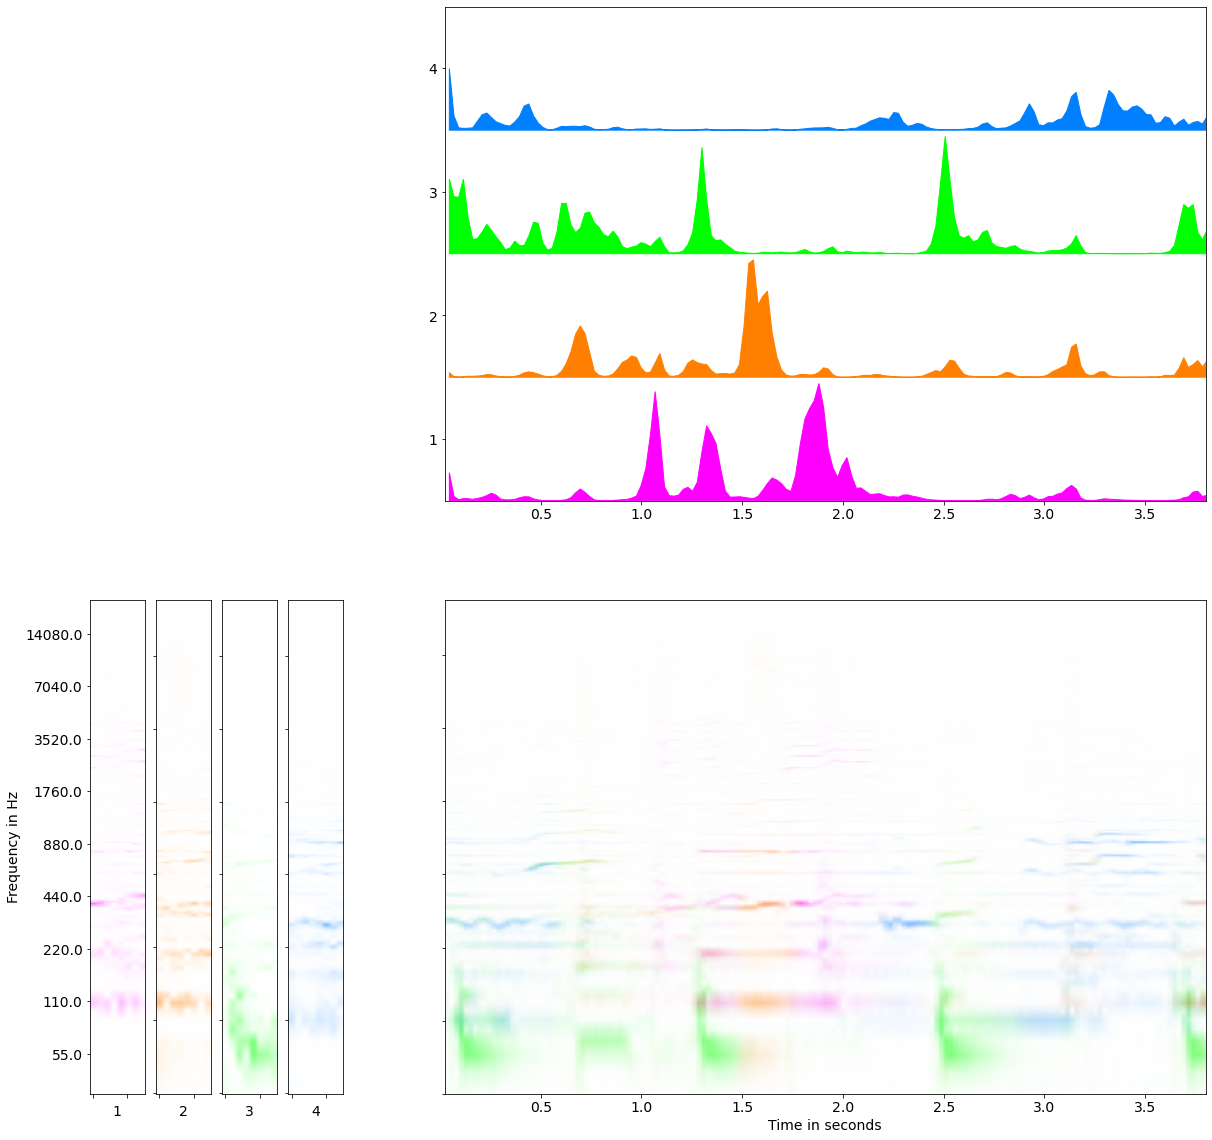

In [132]:
#visualize
paramVis = dict()
paramVis['deltaT'] = deltaT
paramVis['deltaF'] = deltaF
paramVis['endeSec'] = 3.8

# paramVis['endeSec'] = 0.001
paramVis['fontSize'] = 14
fh1, _ = visualizeComponentsNMF(A, nmfdW, nmfdH, nmfdA, paramVis)

In [0]:
audios = []

# resynthesize results of NMF with soft constraints and score information
for k in range(numComp):
    Y = nmfdA[k] * np.exp(1j * P);
    y, _ = inverseSTFT(Y, paramSTFT)
    
    audios.append(y)
    # save result
    
    out_filepath = '/content/nmf_source_separated_output.wav'
    
    wav.write(filename=out_filepath, rate=track_wav.rate, data=y)

## **Mixture track/signal**

In [195]:
display(Audio(x, rate=track_wav.rate))

#### 1st source signal

In [135]:
display(Audio(audios[0].T, rate=track_wav.rate))

#### 2nd source signal

In [136]:
display(Audio(audios[1].T, rate=track_wav.rate))

#### 3rd source signal

In [137]:
display(Audio(audios[2].T, rate=track_wav.rate))

### 4th source signal

In [138]:
display(Audio(audios[3].T, rate=track_wav.rate))

# **Calculate evaluation metrics - SDR, SIR, SAR**

In [0]:
a  = make_monaural(track_wav.stems[0])
b  = make_monaural(track_wav.stems[1])
c  = make_monaural(track_wav.stems[2])
d  = make_monaural(track_wav.stems[3])

reference = np.array([a,b,c,d])
audios = np.array(audios)
reference = reference.reshape(4,300032)
audios = audios.reshape(4, 300032)

In [0]:
sdr, sir, sar, perm = mir_eval.separation.bss_eval_sources(reference, audios)

# As per the **perm** output the best ordering of estimated sources is as follows.

audios[0] - vocals

audios[2] - drums

audios[1] - bass

audios[3] - others


In [197]:
print(perm)

[0 2 1 3]


In [198]:
print('Overall SDR: ', sdr.mean())
print('Overall SIR: ', sir.mean())
print('Overall SAR: ', sar.mean())

Overall SDR:  -1.9925658301663725
Overall SIR:  1.5541774102187669
Overall SAR:  4.006036325989828
